# Coursework 1: Segmentation

------------------------------------------

## <span style="color: red;">1.</span> Thresholding (50 points)

In [1]:
## Importing modules
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

##### Convert the image to a gray image (5 points)

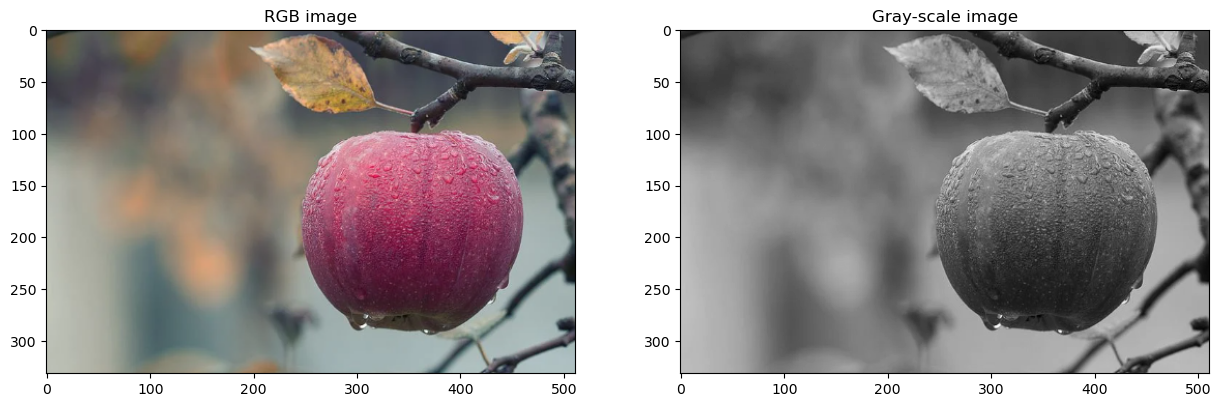

In [2]:
## Import the image
img = cv2.imread('source.png')

## Conversion to gray-scale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

#Conversion to RGB
img_rgb = np.zeros_like(img)
img_rgb[:,:,0] = img[:,:,2]
img_rgb[:,:,1] = img[:,:,1]
img_rgb[:,:,2] = img[:,:,0]
img = img_rgb

#Conversion from [0, 255] to [0, 1]
img = img.astype(np.float32) / 255.
gray_img = gray_img.astype(np.float32) / 255.

#Plotting
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('RGB image')
plt.subplot(1, 2, 2)
plt.imshow(gray_img, cmap='gray', label="Gray-scale image")
plt.title('Gray-scale image')
plt.show()

##### Implement a function to threshold the image by a threshold value t (20 points)

In [3]:
def threshold_t(img, t):
    '''
    Impelemnt 
    :param img: gray-scaled image 
    :param t: threshold value
    :return result: the binary image with 0 when above threshold and 1 otherwise
    '''
    result = np.zeros_like(img)+1
    result[img>t] = 0 # If the pixel is above the treshold, we hide it (= 0)
    return result

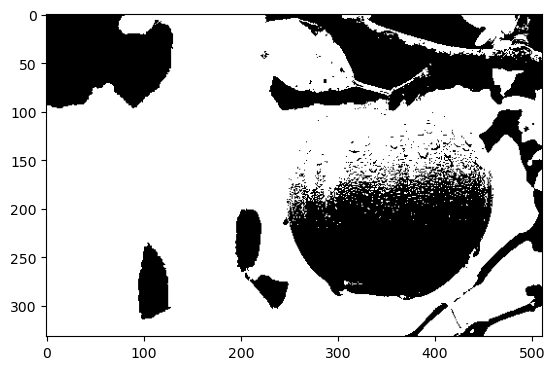

In [4]:
# Plotting the result
t = 0.4
segm_img = threshold_t(gray_img, t)
plt.imshow(segm_img, cmap='binary')
plt.show()

##### Plot the ROC curve of that method under varying t (13 points) and submit this as an image file in sufficient quality (2 points)

In [13]:
# Function that computes the ROC curve

def ROC(src, tgt):
    '''
    Impelemnt 
    :param src: segmented image we want to compare
    :param tgt: target image that contains the ground-truth segmentation
    :return : the false-positive-ratio and the true-positive-ratio
    '''
    h, w = src.shape # Gray-scale only
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for i in range(h):
        for j in range(w):
            s = src[i, j]
            t = tgt[i, j]
            if(s == 0 and t == 0):
                tn += 1
            elif(s == 1 and t == 1):
                tp += 1
            elif(s == 0 and t == 1):
                fn += 1
            else:
                fp += 1

    return (fp/(fp+tn)), (tp/(tp+fn))

In [14]:
# Let's import the target image

tgt = cv2.imread('target.png')
tgt = tgt.astype(np.float32) / 255.
gray_tgt = cv2.cvtColor(tgt, cv2.COLOR_BGR2GRAY)

In [15]:
# Let's compute the ROC curve 
t = np.linspace(0, 1)
TP_frac = np.array([])
FP_frac = np.array([])

for t_k in t:
    FP_frac_val, TP_frac_val = ROC(threshold_t(gray_img, t_k), gray_tgt)
    TP_frac = np.append(TP_frac, TP_frac_val)
    FP_frac = np.append(FP_frac, FP_frac_val)

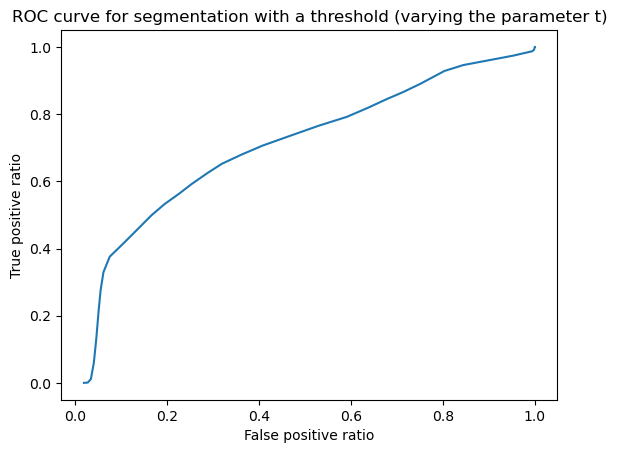

In [16]:
# Plotting and saving the figure

plt.plot(FP_frac, TP_frac)
plt.xlabel("False positive ratio")
plt.ylabel("True positive ratio")
plt.title("ROC curve for segmentation with a threshold (varying the parameter t)")
plt.savefig('ROC_curve.png')
plt.show()

##### What is the optimal threshold t (5 points), if precision and recall are weighted equally?

We can display the histogram of the gray-scale image, so that we can try to find a t-value that would separate the foreground and background values (the background values should be darker, so on the left of the histogram).

In [17]:
def compute_hist(img):
    '''
    Impelemnt 
    :param img: gray scaled image with size HxW
    :return h: image histogram
    '''
    r,c = img.shape
    h = np.zeros((256,1))
    for i in range(r):
        for j in range(c):
            h[int(img[i, j]), 0] += 1
    
    return h

Text(0.5, 1.0, 'Histogram of the gray-scale image')

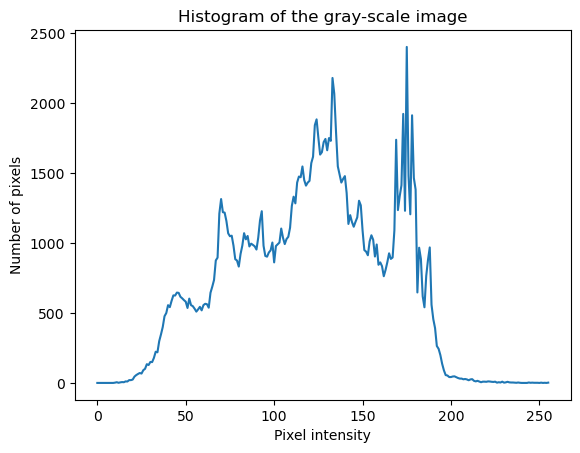

In [18]:
img_hist = compute_hist(gray_img*255) # Let's not forget to multiply by 255 to have discrete integer values
plt.plot(img_hist)
plt.xlabel("Pixel intensity")
plt.ylabel("Number of pixels")
plt.title("Histogram of the gray-scale image")

According to the histogram, we could choose a value between 100 and 150. We'll choose 140.
The optimal t should therefore be t = 140/255 = 0.55

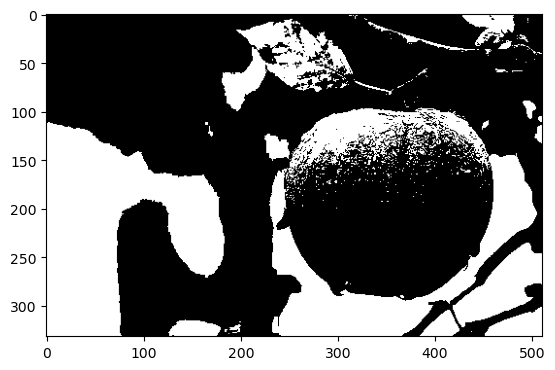

In [19]:
# Plotting the result
t = 140/255
segm_img = threshold_t(gray_img, t)
plt.imshow(segm_img, cmap='binary')
plt.show()

#####  Is there a better linear method to convert the RGB into the gray image, so that a sweep results in a better result (5 points)?

With some research, we have found that OpenCV actually does not perform a linear conversion to gray-scale. We can therefore see if our basic mean-conversion works better.

In [20]:
gray_img_2 = np.mean(img, axis=2)

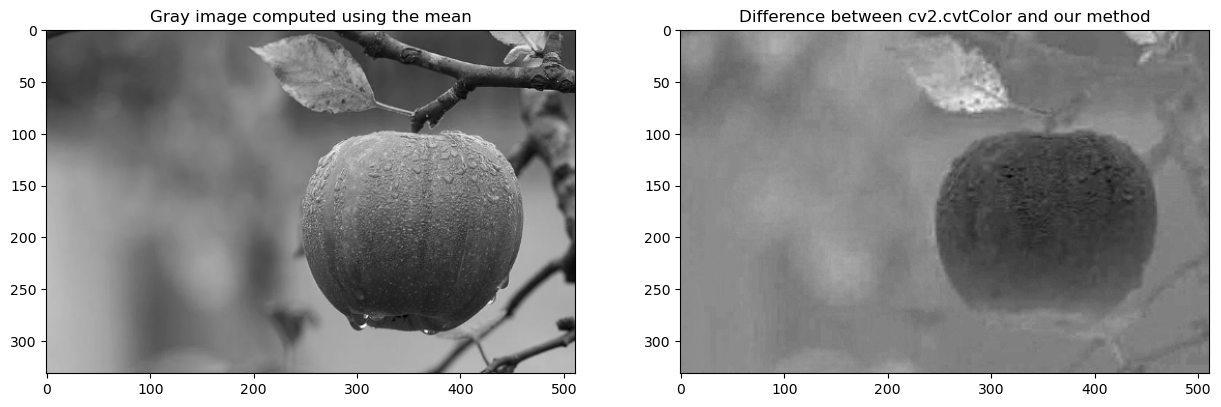

In [21]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(np.mean(img, axis=2), cmap='gray')
plt.title('Gray image computed using the mean')
plt.subplot(122)
plt.imshow(gray_img-gray_img_2, cmap='gray')
plt.title('Difference between cv2.cvtColor and our method')
plt.show()

As we can see, we do not obtain the same result. Let's compute the ROC curve and look at the new histogram.

In [22]:
# New histogram
img_hist_2 = compute_hist(gray_img_2*255)

# New ROC curve
t = np.linspace(0, 1)
TP_frac_2 = np.array([])
FP_frac_2 = np.array([])

for t_k in t:
    FP_frac_val, TP_frac_val = ROC(threshold_t(gray_img_2, t_k), gray_tgt)
    TP_frac_2 = np.append(TP_frac_2, TP_frac_val)
    FP_frac_2 = np.append(FP_frac_2, FP_frac_val)

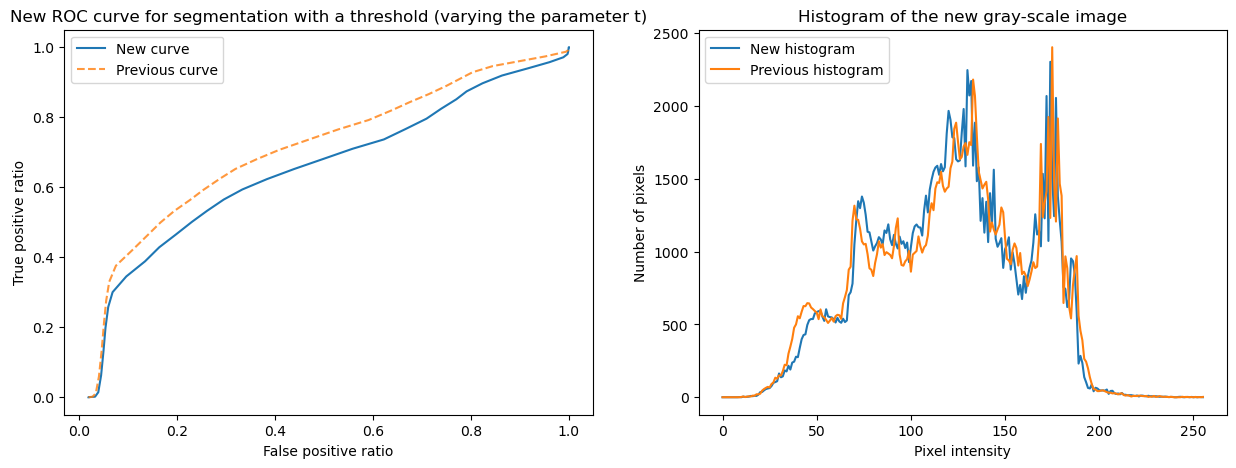

In [23]:
# Plotting

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(FP_frac_2, TP_frac_2, label="New curve")
plt.plot(FP_frac, TP_frac, '--', label="Previous curve", alpha=0.8)
plt.legend()
plt.xlabel("False positive ratio")
plt.ylabel("True positive ratio")
plt.title("New ROC curve for segmentation with a threshold (varying the parameter t)")
plt.subplot(122)
plt.plot(img_hist_2, label="New histogram")
plt.plot(img_hist, label='Previous histogram')
plt.legend()
plt.xlabel("Pixel intensity")
plt.ylabel("Number of pixels")
plt.title("Histogram of the new gray-scale image")
plt.show()

Our new transform actually has worse performances compared to the OpenCV conversion.

----------------

## <span style="color: red;">2.</span> Clustering (50 points)

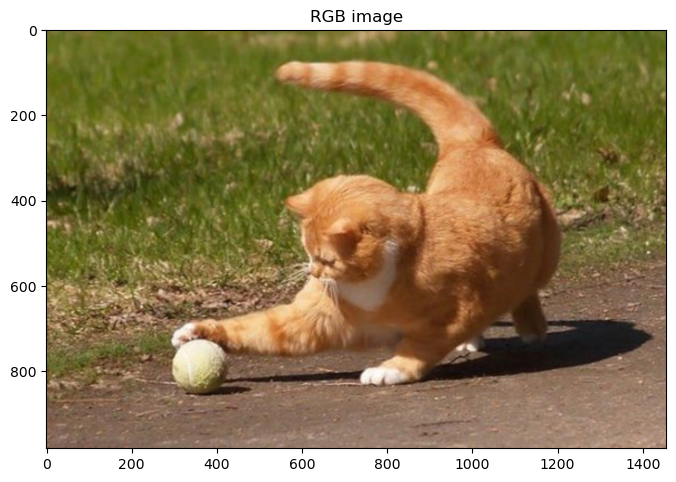

In [24]:
## Import the image
img = cv2.imread('clustering.png')

#Conversion to RGB
img_rgb = np.zeros_like(img)
img_rgb[:,:,0] = img[:,:,2]
img_rgb[:,:,1] = img[:,:,1]
img_rgb[:,:,2] = img[:,:,0]
img = img_rgb

#Conversion from [0, 255] to [0, 1]
img = img.astype(np.float32) / 255.

#Plotting
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.title('RGB image')
plt.show()

##### Implement a function to segment the image using k-means using only color (25 points) and using color and position (10 points) as features.

We will have a general k-means function, and we'll test it with the input image, and then an array where we will have attached the position to each pixel.

In [25]:
def kmeans(X, k, max_iterations=1000):
    """
    Write your implementation of kmeans here.

    Arguments:
    X : Data matrix.
    k : Number of clusters
    max_iterations : The number of iterations after which to stop.

    Returns:
    L: An array storing the belonging of each point to what cluster.
    """

    #begin_solution
    
    # Write your code here:
    epsilon = 1e-6
    
    h, w, c = X.shape # Collecting the shape of the input data matrix
    
    clusters = np.zeros((k, c))
    for t in range(k): # Initializing the clusters to random pixels in the image
        clusters[t, :] = X[np.random.randint(0, h), np.random.randint(0, w), :]
    
    L = np.zeros((h, w), dtype=int) #L keeps in memory to which mean we have assigned each point
    
    previous_clusters = clusters
    
    # First loop: we assign the x's to the different means
    for i in range(h):
        for j in range(w):
            pt_value = X[i, j, :] # Iterating on the x's
            best_distance = np.linalg.norm(pt_value-clusters[0, :]) # We do as if the first centre was ok, given that L is initialized as only zeroes
            for t in range(1, k): # Iterating on the means
                if(np.linalg.norm(pt_value-clusters[t, :]) < best_distance): # If the distance to this mean is less than the best one, we update
                    L[i, j] = t
                    best_distance = np.linalg.norm(pt_value-clusters[t, :])
            
    # Second loop: we update the mean
    sum_values = np.zeros_like(clusters)
    nb_of_points = np.zeros(k)
    for i in range(h):
        for j in range(w):
            sum_values[L[i, j], :] += X[i, j, :]
            nb_of_points[L[i, j]] += 1 
    for t in range(1, k):
        clusters[t, :] = sum_values[t, :]/(nb_of_points[t]+epsilon) # POSSIBLE DIVISION BY 0
            
    #While loop: max iterations
    nb_of_iterations = 0
    while(nb_of_iterations < max_iterations):
        
        #We break out of the loop if the centroids stay too similar between two iterations
        if(np.linalg.norm(clusters-previous_clusters)<epsilon):
            break
        
        #We stock the clusters we have, so as to compute new ones
        previous_clusters = clusters
        
        # First loop: we assign the x's to the different means
        for i in range(h):
            for j in range(w):
                pt_value = X[i, j, :] # Iterating on the x's
                prev_distance = np.linalg.norm(pt_value-clusters[0, :]) # We do as if the first centre was ok, given that L is initialized as only zeroes
                for t in range(1, k): # Iterating on the means
                    if(np.linalg.norm(pt_value-clusters[t, :]) < prev_distance): # If the distance to this mean is less than the best one, we update
                        L[i, j] = t
                        prev_distance = np.linalg.norm(pt_value-clusters[t, :])
            
        # Second loop: we update the mean
        sum_values = np.zeros_like(clusters)
        nb_of_points = np.zeros(k)
        for pt_idx in range(n):
            sum_values[L[i, j], :] += X[i, j, :]
            nb_of_points[L[i, j]] += 1 
        for t in range(1, k):
            clusters[t, :] = sum_values[t, :]/(nb_of_points[t]+epsilon)
        
        nb_of_iterations += 1

    return L, clusters

In [26]:
# Creating the position+colour array

h, w, c = img.shape
img_pos = np.zeros((h, w, 5))
for i in range(h):
    for j in range(w):
        img_pos[i, j, :] = np.array([i/h, j/w, img[i, j, 0], img[i, j, 1], img[i, j, 2]])

In [27]:
# Computing the clusters and belongings

L_c, clusters_c = kmeans(img, 4)
L_pc, clusters_pc = kmeans(img_pos, 4)

In [28]:
# Let's replace the indices (0, 1, 2..) by the value of each centroid
# (_c for colour and _pc for position+colour)
clustered_img_c = np.zeros((h, w, 3))
clustered_img_pc = np.zeros((h, w, 3))

for i in range(h):
    for j in range(w):
        clustered_img_c[i, j, :] = clusters_c[L_c[i, j], :]
        clustered_img_pc[i, j, :] = clusters_pc[L_pc[i, j], 2:]

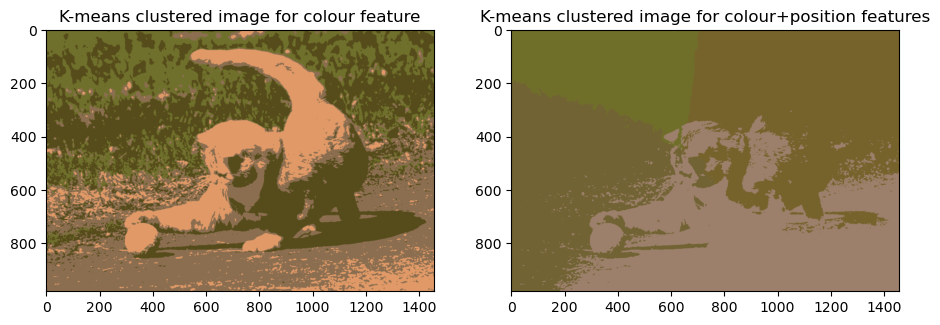

In [29]:
# Plotting

plt.figure(figsize=(11,11))
plt.subplot(121)
plt.imshow(clustered_img_c)
plt.title('K-means clustered image for colour feature')
plt.subplot(122)
plt.imshow(clustered_img_pc)
plt.title('K-means clustered image for colour+position features')
plt.show()

##### Implement a method to L2-compare the input image and its clustered version, i.e., an image where every pixel is replaced by the mean color of its cluster (10 points). Let is call this the “error”.

In [30]:
# Let's define the L2-error

def l2_error(img, clustered_img):
    return np.linalg.norm(img-clustered_img)

In [31]:
print("For examples, here are the errors computed for both methods:")
print("Only colour feature: "+str(l2_error(img, clustered_img_c)))
print("Colour and position features: "+str(l2_error(img, clustered_img_pc)))

For examples, here are the errors computed for both methods:
Only colour feature: 161.35048090859067
Colour and position features: 287.49995824701455


##### The algorithms has a free parameter: the number of clusters k for k-means. Plot two error curves for varying k for both the color and color-and-position version of the algorithm (5 points). The horizontal axis is k, the vertical axis is the image error.

In [32]:
def plotting_curves(img, img_pc, k_range):
    
    assert k_range > 2, f'Please enter a k_range value greater than 2'
    h, w, c = img.shape
    error_c = np.array([])
    error_pc = np.array([])
    k_x = np.arange(2, k_range+1)
    
    for k in range(2, k_range+1):
        
        # Clustering
        L_c, clusters_c = kmeans(img, k)
        L_pc, clusters_pc = kmeans(img_pc, k)
        
        # Replacement of the indices by the mean pixel value
        clustered_img_c = np.zeros((h, w, 3))
        clustered_img_pc = np.zeros((h, w, 3))
        for i in range(h):
            for j in range(w):
                clustered_img_c[i, j, :] = clusters_c[L_c[i, j], :]
                clustered_img_pc[i, j, :] = clusters_pc[L_pc[i, j], 2:]
        
        # Computing the error
        error_c = np.append(error_c, l2_error(img, clustered_img_c))
        error_pc = np.append(error_pc, l2_error(img, clustered_img_pc))
    
    # Plotting
    plt.plot(k_x, error_c, label="Only colour")
    plt.plot(k_x, error_pc, label="Colour + Position")
    plt.legend()
    plt.xlabel('Number of clusters')
    plt.ylabel('L2-error')
    plt.title('L2-error between the clustered images and the ground-truth')
    plt.show()    
    

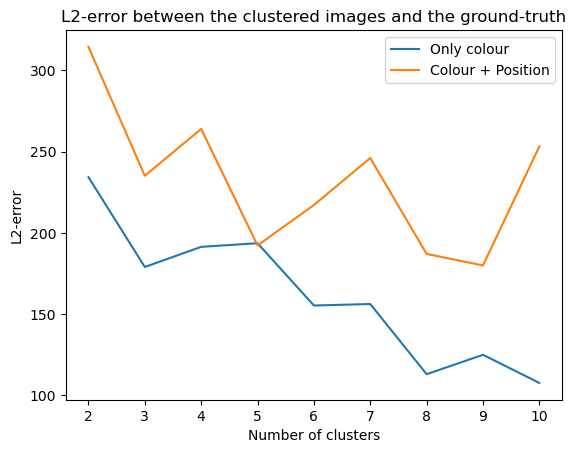

In [33]:
plotting_curves(img, img_pos, 10)

From what we can observe, the only-colour model performs better than the colour+position one. This can be explained by the fact that we have to find a clever way to map the coordinates to the feature-vector: at first, we put the i, j coordinates as is in the vector, but as the pixel value was between 0 and 1, we had terrible results because the mean was too high. We took i/h and j/w to centre between 0 and 1 too. But the function makes no difference between colour coordinates and position coordinates. We might be interested in dividing the k-means in two tasks: position and colour, and then taking the average of both.

For k = 5, we seem to have a good compromise, especially for the colour+position model.

$$ \% $$